<a href="https://colab.research.google.com/github/qeqs/road_to_phd/blob/main/LPA_REGUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch==2.2.1+cu121 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
!pip3 install torch_geometric -f https://data.pyg.org/whl/torch-2.2.1+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html


In [3]:
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link



In [4]:
!pip install torch-scatter==2.1.2+pt22cu121 -f https://data.pyg.org/whl/torch-2.2.1+cu121.html
!pip install torch-cluster==1.6.3+pt22cu121 -f https://data.pyg.org/whl/torch-2.2.1+cu121.html
!pip install torch-sparse==0.6.18+pt22cu121 -f https://data.pyg.org/whl/torch-2.2.1+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: torch-cluster
    Found existing installation: torch_cluster 1.6.3+pt22cu118
    Uninstalling torch_cluster-1.6.3+pt22cu118:
      Successfully uninstalled torch_cluster-1.6.3+pt22cu118
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html


In [5]:
import torch
print(torch.__version__)

2.2.1+cu121


In [6]:
import numpy as np
import scipy.sparse as sp
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_scatter import scatter

def one_hot_embedding(labels, num_classes):
    y = torch.eye(num_classes).cuda()
    return y[labels] #scatter(y, labels, dim=0)


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def load_data(dataset):
    data = dataset[0]
    train_mask = torch.zeros(data.num_nodes).to(torch.bool)
    val_mask = torch.zeros(data.num_nodes).to(torch.bool)
    test_mask = torch.zeros(data.num_nodes).to(torch.bool)
    for i in range(0, int(0.6 * data.num_nodes)):
        train_mask[i] = True
    for i in range(int(0.6 * data.num_nodes), int(0.8 * data.num_nodes)):
        val_mask[i] = True
    for i in range(int(0.8 * data.num_nodes), data.num_nodes):
        test_mask[i] = True
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask
    return data


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [7]:
from typing import Callable, Optional
from torch_geometric.typing import Adj, OptTensor

import torch
from torch import Tensor
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm


class LPAconv(MessagePassing):
    def __init__(self, num_layers: int):
        super(LPAconv, self).__init__(aggr='add')
        self.num_layers = num_layers

    def forward(
            self, y: Tensor, edge_index: Adj, mask: Optional[Tensor] = None,
            edge_weight: OptTensor = None,
            post_step: Callable = lambda y: y.clamp_(0., 1.)
    ) -> Tensor:

        if y.dtype == torch.int64:
            y = F.one_hot(y.view(-1)).to(torch.float)

        out = y
        if mask is not None:
            out = torch.zeros_like(y)
            out[mask] = y[mask]

        if isinstance(edge_index, SparseTensor) and not edge_index.has_value():
            edge_index = gcn_norm(edge_index, add_self_loops=False)
        elif isinstance(edge_index, Tensor) and edge_weight is None:
            edge_index, edge_weight = gcn_norm(edge_index, num_nodes=y.size(0),
                                               add_self_loops=False)

        for _ in range(self.num_layers):
            # propagate_type: (y: Tensor, edge_weight: OptTensor)
            out = self.propagate(edge_index, x=out, edge_weight=edge_weight,
                                 size=None)
            # out = post_step(out)
        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor = None) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor = None) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv
from torch_geometric.nn import MLP as t_MLP

class MLP(nn.Module):
    def __init__(self, in_feature, hidden, out_feature, dropout):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_feature, hidden)
        self.fc2 = nn.Linear(hidden, out_feature)
        self.relu = nn.ReLU()
        self.dropout_rate = dropout

    def forward(self, data):
        x = data.x
        x = self.fc1(x)
        x = self.relu(x)
        x = F.dropout(x, self.dropout_rate, training=self.training)

        x = self.fc2(x)

        return x


class GCN(nn.Module):
    def __init__(self, in_feature, hidden, out_feature, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_feature, hidden)
        self.conv2 = GCNConv(hidden, out_feature)
        self.dropout_rate = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x, edge_index = x, edge_index
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)

        x = F.dropout(x, self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)

        return F.log_softmax(x, dim=1)


class GCN_LPA(nn.Module):
    def __init__(self, in_feature, hidden, out_feature, dropout, num_edges, lpaiters, gcnnum):
        super(GCN_LPA, self).__init__()
        self.edge_weight = nn.Parameter(torch.ones(num_edges))
        gc = nn.ModuleList()
        gc.append(GCNConv(in_feature, hidden))
        for i in range(gcnnum-2):
            gc.append(GCNConv(hidden, hidden))
        gc.append(GCNConv(hidden, out_feature))
        self.gc = gc
        self.lpa = LPAconv(lpaiters)
        self.dropout_rate = dropout

    def forward(self, data, mask):
        x, edge_index, y = data.x, data.edge_index, data.y

        for i in range(len(self.gc)-1):
            x = self.gc[i](x, edge_index, self.edge_weight)
            x = F.relu(x)
            x = F.dropout(x, self.dropout_rate, training=self.training)
        x = self.gc[-1](x, edge_index, self.edge_weight)

        y_hat = self.lpa(y, edge_index, mask, self.edge_weight) # y???

        return x, y_hat



class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=1, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        return F.log_softmax(x, dim=1)


class GraphSAGE_LPA(nn.Module):
    def __init__(self, in_feature, hidden, out_feature, dropout, num_edges, lpaiters, gcnnum):
        super(GraphSAGE_LPA, self).__init__()

        self.edge_weight = nn.Parameter(torch.ones(num_edges))
        gc = nn.ModuleList()
        gc.append(SAGEConv(in_feature, hidden, aggr='mean'))
        for i in range(gcnnum-2):
            gc.append(SAGEConv(hidden, hidden, aggr='mean'))
        gc.append(SAGEConv(hidden, out_feature, aggr='mean'))
        self.gc = gc
        self.lpa = LPAconv(lpaiters)
        self.dropout_rate = dropout

    def forward(self, data, mask):
        x, edge_index, y = data.x, data.edge_index, data.y

        for i in range(len(self.gc)-1):
            x = self.gc[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, self.dropout_rate, training=self.training)
        x = self.gc[-1](x, edge_index)

        y_hat = self.lpa(y, edge_index, mask, self.edge_weight)

        return x, y_hat

from torch_geometric.nn import GATConv, TopKPooling

# class GAT(nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, num_heads=1):
#         super(GAT, self).__init__()
#         self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=0.6)
#         self.conv2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, concat=False, dropout=0.6)

#     def forward(self, x, edge_index):
#         x = F.elu(self.conv1(x, edge_index))
#         x = F.elu(self.conv2(x, edge_index))
#         return F.log_softmax(x, dim=1)

class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2, dropout=0.6, gcnnum=2):
        super(GAT, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        hidden_channels_list = [hidden_channels]
        for _ in range(1, gcnnum-1):
            self.convs.append(GATConv(hidden_channels_list[i - 1] * heads, hidden_channels[i], heads=heads, dropout=dropout))
            hidden_channels_list.append(hidden_channels_list[i - 1] * heads)
        self.convs.append(GATConv(hidden_channels_list[-1] * heads, out_channels, heads=1, dropout=dropout))

    def forward(self, x, edge_index, edge_weight=None):
        for conv in self.convs:
            x = conv(x, edge_index, edge_weight)
            x = F.elu(x)
            x = F.dropout(x, training=self.training)
        return F.log_softmax(x, dim=1)

class GAT_LPA(nn.Module):
    def __init__(self, in_feature, hidden, out_feature, dropout, num_edges, lpaiters, gcnnum):
        super(GAT_LPA, self).__init__()
        self.edge_weight = nn.Parameter(torch.ones(num_edges))
        gc = nn.ModuleList()
        gc.append(GATConv(in_feature, hidden, heads=1, dropout=0.6))
        for i in range(gcnnum-2):
            gc.append(GATConv(hidden, hidden, heads=1, dropout=0.6))
        gc.append(GATConv(hidden, out_feature, heads=1, dropout=0.6))
        self.gc = gc
        self.lpa = LPAconv(lpaiters)
        self.dropout_rate = dropout

    def forward(self, data, mask):
        x, edge_index, y = data.x, data.edge_index, data.y

        for i in range(len(self.gc)-1):
            x = self.gc[i](x, edge_index, self.edge_weight)
            x = F.relu(x)
            x = F.dropout(x, self.dropout_rate, training=self.training)
        x = self.gc[-1](x, edge_index, self.edge_weight)

        y_hat = self.lpa(y, edge_index, mask, self.edge_weight)

        return x, y_hat

In [9]:
# prompt: testing of algorithms GCN_LPA GraphSAGE_LPA GAT_LPA 10 times each with output of pandas dataframe with mean accuracy  and 95% confidence intervals

import pandas as pd
from torch_geometric.datasets import Planetoid, Coauthor
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.loader import DataLoader
from sklearn.metrics import confusion_matrix, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import time
import numpy as np


crition = nn.CrossEntropyLoss()

hidden_channels = 16
num_layers = 2
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
epochs = 200
lamda = 0.1
lpaiters = 5


def train_model_lpa(model, data, mask):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    out, yhat = model(data, data.train_mask)
    loss_train = crition(out[data.train_mask], data.y[data.train_mask]) \
                 + lamda * crition(yhat[data.train_mask], data.y[data.train_mask])
    # acc_train = accuracy(out[data.train_mask], data.y[data.train_mask])
    loss_train.backward()
    optimizer.step()

def test_model_lpa(model, data, mask):
    model.eval()
    _, pred = model(data, data.test_mask)[0].max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

def train_model_baseline(model, data, mask):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)[data.train_mask]
    loss_train = crition(out, data.y[data.train_mask])
    loss_train.backward()
    optimizer.step()


def test_model_baseline(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_weight)[data.test_mask]
    pred = out.argmax(dim=1)
    acc = accuracy(pred, data.y[data.test_mask])
    return acc


def accuracy(out, labels):
    correct = int(out.eq(labels).sum().item())
    return correct / int(data.test_mask.sum())

device = torch.device('cuda')



results = []

for dataset_name in ['Cora', 'Citeseer', 'Pubmed', 'CoauthorCS', 'CoauthorPh']:

  if dataset_name in ['Cora', 'Citeseer', 'Pubmed']:
    dataset = Planetoid(root=f'/tmp/{dataset_name}', name=dataset_name)
  else:
    dataset = Coauthor(root=f'/tmp/{dataset_name}', name='CS' if dataset_name == 'CoauthorCS' else 'Physics')

  data = load_data(dataset)
  data = data.cuda()
  for model_name in  ['GCN', 'GAT', 'GCN_LPA', 'GAT_LPA']: #[ 'GCN', 'GraphSAGE', 'GAT', 'GCN_LPA', 'GraphSAGE_LPA', 'GAT_LPA']:# 'GCN_LPA', 'GraphSAGE_LPA', 'GAT_LPA',
      print(f"{dataset_name} {model_name}")
      for i in range(50):
          if model_name == 'GCN_LPA':
              model = GCN_LPA(dataset.num_node_features, hidden_channels, dataset.num_classes, dropout, data.num_edges, 5, num_layers)
          elif model_name == 'GraphSAGE_LPA':
              model = GraphSAGE_LPA(dataset.num_node_features, hidden_channels, dataset.num_classes, dropout, data.num_edges, 5, num_layers)
          elif model_name == 'GAT_LPA':
              model = GAT_LPA(dataset.num_node_features, hidden_channels, dataset.num_classes, dropout, data.num_edges, 5, num_layers)
          elif model_name == 'GCN':
              model = GCN(in_feature=dataset.num_features, hidden=hidden_channels, out_feature=dataset.num_classes, dropout=dropout)
          elif model_name == 'GraphSAGE':
              model = GraphSAGE(in_channels=dataset.num_features, hidden_channels=hidden_channels, out_channels=dataset.num_classes)
          elif model_name == 'GAT':
              model = GAT(in_channels=dataset.num_features, hidden_channels=hidden_channels, out_channels=dataset.num_classes)
          model = model.to(device)
          criterion = nn.CrossEntropyLoss()
          optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
          if "LPA" in model_name:
              train_model = train_model_lpa
              test_model = test_model_lpa
          else:
              train_model = train_model_baseline
              test_model = test_model_baseline

          for epoch in range(epochs):
              train_model(model, data, data.train_mask)

          test_acc = test_model(model, data, data.test_mask)

          print(f"Iter: {i}, acc: {test_acc}")
          if test_acc < 0.7:
              continue
          results.append([model_name,dataset_name, test_acc])

def confidence_interval(data):
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # Using Bessel's correction for sample standard deviation
    n = len(data)
    std_error = std_dev / np.sqrt(n)
    margin_of_error = 1.96 * std_error  # Z-score for 95% confidence interval
    return margin_of_error

df = pd.DataFrame(results, columns=['Model', 'Dataset', 'Accuracy'])



Processing...
Done!


Cora GCN
Iter: 0, acc: 0.8726937269372693
Iter: 1, acc: 0.8763837638376384
Iter: 2, acc: 0.8726937269372693
Iter: 3, acc: 0.8671586715867159
Iter: 4, acc: 0.8745387453874539
Iter: 5, acc: 0.8597785977859779
Iter: 6, acc: 0.8726937269372693
Iter: 7, acc: 0.8671586715867159
Iter: 8, acc: 0.8616236162361623
Iter: 9, acc: 0.8653136531365314
Iter: 10, acc: 0.8653136531365314
Iter: 11, acc: 0.8745387453874539
Iter: 12, acc: 0.8690036900369004
Iter: 13, acc: 0.8708487084870848
Iter: 14, acc: 0.8708487084870848
Iter: 15, acc: 0.8671586715867159
Iter: 16, acc: 0.8708487084870848
Iter: 17, acc: 0.8782287822878229
Iter: 18, acc: 0.8726937269372693
Iter: 19, acc: 0.8763837638376384
Iter: 20, acc: 0.8745387453874539
Iter: 21, acc: 0.8690036900369004
Iter: 22, acc: 0.8708487084870848
Iter: 23, acc: 0.8745387453874539
Iter: 24, acc: 0.8819188191881919
Iter: 25, acc: 0.8671586715867159
Iter: 26, acc: 0.8782287822878229
Iter: 27, acc: 0.8745387453874539
Iter: 28, acc: 0.8597785977859779
Iter: 29, acc: 

Processing...
Done!


Citeseer GCN
Iter: 0, acc: 0.7597597597597597
Iter: 1, acc: 0.7642642642642643
Iter: 2, acc: 0.7567567567567568
Iter: 3, acc: 0.7582582582582582
Iter: 4, acc: 0.7597597597597597
Iter: 5, acc: 0.7567567567567568
Iter: 6, acc: 0.7597597597597597
Iter: 7, acc: 0.7522522522522522
Iter: 8, acc: 0.7507507507507507
Iter: 9, acc: 0.7627627627627628
Iter: 10, acc: 0.7552552552552553
Iter: 11, acc: 0.7597597597597597
Iter: 12, acc: 0.7582582582582582
Iter: 13, acc: 0.7567567567567568
Iter: 14, acc: 0.7492492492492493
Iter: 15, acc: 0.7612612612612613
Iter: 16, acc: 0.7702702702702703
Iter: 17, acc: 0.7507507507507507
Iter: 18, acc: 0.7522522522522522
Iter: 19, acc: 0.7537537537537538
Iter: 20, acc: 0.7612612612612613
Iter: 21, acc: 0.7567567567567568
Iter: 22, acc: 0.7582582582582582
Iter: 23, acc: 0.7567567567567568
Iter: 24, acc: 0.7537537537537538
Iter: 25, acc: 0.7582582582582582
Iter: 26, acc: 0.7492492492492493
Iter: 27, acc: 0.7582582582582582
Iter: 28, acc: 0.7552552552552553
Iter: 29, a

Processing...
Done!


Pubmed GCN
Iter: 0, acc: 0.867393509127789
Iter: 1, acc: 0.8699290060851927
Iter: 2, acc: 0.8711967545638946
Iter: 3, acc: 0.8661257606490872
Iter: 4, acc: 0.8699290060851927
Iter: 5, acc: 0.8696754563894523
Iter: 6, acc: 0.8681541582150102
Iter: 7, acc: 0.8686612576064908
Iter: 8, acc: 0.8706896551724138
Iter: 9, acc: 0.8691683569979716
Iter: 10, acc: 0.8689148073022313
Iter: 11, acc: 0.8681541582150102
Iter: 12, acc: 0.8689148073022313
Iter: 13, acc: 0.8666328600405679
Iter: 14, acc: 0.8704361054766734
Iter: 15, acc: 0.8696754563894523
Iter: 16, acc: 0.8701825557809331
Iter: 17, acc: 0.8676470588235294
Iter: 18, acc: 0.8696754563894523
Iter: 19, acc: 0.8679006085192698
Iter: 20, acc: 0.869421906693712
Iter: 21, acc: 0.867393509127789
Iter: 22, acc: 0.8653651115618661
Iter: 23, acc: 0.8681541582150102
Iter: 24, acc: 0.8696754563894523
Iter: 25, acc: 0.8696754563894523
Iter: 26, acc: 0.8681541582150102
Iter: 27, acc: 0.8684077079107505
Iter: 28, acc: 0.8676470588235294
Iter: 29, acc: 0

Processing...
Done!


CoauthorCS GCN
Iter: 0, acc: 0.9375511317152986
Iter: 1, acc: 0.9394600490864466
Iter: 2, acc: 0.9386419416416689
Iter: 3, acc: 0.9394600490864466
Iter: 4, acc: 0.9389146441232615
Iter: 5, acc: 0.9375511317152986
Iter: 6, acc: 0.9370057267521135
Iter: 7, acc: 0.9397327515680393
Iter: 8, acc: 0.9391873466048541
Iter: 9, acc: 0.9386419416416689
Iter: 10, acc: 0.9380965366784838
Iter: 11, acc: 0.9372784292337061
Iter: 12, acc: 0.9397327515680393
Iter: 13, acc: 0.9378238341968912
Iter: 14, acc: 0.9383692391600763
Iter: 15, acc: 0.9383692391600763
Iter: 16, acc: 0.940550859012817
Iter: 17, acc: 0.9380965366784838
Iter: 18, acc: 0.9397327515680393
Iter: 19, acc: 0.9378238341968912
Iter: 20, acc: 0.9375511317152986
Iter: 21, acc: 0.9375511317152986
Iter: 22, acc: 0.9383692391600763
Iter: 23, acc: 0.9397327515680393
Iter: 24, acc: 0.9364603217889282
Iter: 25, acc: 0.9380965366784838
Iter: 26, acc: 0.9378238341968912
Iter: 27, acc: 0.9383692391600763
Iter: 28, acc: 0.9372784292337061
Iter: 29, 

Processing...
Done!


CoauthorPh GCN
Iter: 0, acc: 0.9684012175677634
Iter: 1, acc: 0.9691259602840991
Iter: 2, acc: 0.9678214233946949
Iter: 3, acc: 0.9686911146542977
Iter: 4, acc: 0.9685461661110306
Iter: 5, acc: 0.9682562690244964
Iter: 6, acc: 0.9686911146542977
Iter: 7, acc: 0.9686911146542977
Iter: 8, acc: 0.9673865777648935
Iter: 9, acc: 0.9682562690244964
Iter: 10, acc: 0.9681113204812292
Iter: 11, acc: 0.9682562690244964
Iter: 12, acc: 0.9684012175677634
Iter: 13, acc: 0.9676764748514277
Iter: 14, acc: 0.9684012175677634
Iter: 15, acc: 0.966951732135092
Iter: 16, acc: 0.9684012175677634
Iter: 17, acc: 0.9682562690244964
Iter: 18, acc: 0.9675315263081606
Iter: 19, acc: 0.9681113204812292
Iter: 20, acc: 0.967966371937962
Iter: 21, acc: 0.9684012175677634
Iter: 22, acc: 0.9678214233946949
Iter: 23, acc: 0.9682562690244964
Iter: 24, acc: 0.967966371937962
Iter: 25, acc: 0.9682562690244964
Iter: 26, acc: 0.9672416292216264
Iter: 27, acc: 0.9685461661110306
Iter: 28, acc: 0.9681113204812292
Iter: 29, ac

In [10]:
df = pd.DataFrame(results, columns=['Model', 'Dataset', 'Accuracy'])
dd = df.groupby(['Model', 'Dataset'])['Accuracy'].agg(['mean', confidence_interval])
dd['mean_ci'] =  np.round(dd['mean'], 3).astype(str) + ' ± ' + np.round(dd['confidence_interval'], 3).astype(str)
dd = dd.drop(['mean', 'confidence_interval'], axis=1)
dd.pivot_table(values=['mean_ci'], index=['Model'], columns=['Dataset'], aggfunc=lambda x: x)

mean_ci                                                        
Dataset       Citeseer   CoauthorCS   CoauthorPh           Cora         Pubmed
Model                                                                         
GAT      0.763 ± 0.002  0.932 ± 0.0  0.964 ± 0.0  0.882 ± 0.001    0.858 ± 0.0
GAT_LPA  0.766 ± 0.001  0.931 ± 0.0  0.964 ± 0.0  0.886 ± 0.001  0.856 ± 0.001
GCN      0.758 ± 0.001  0.939 ± 0.0  0.968 ± 0.0  0.871 ± 0.001    0.868 ± 0.0
GCN_LPA  0.759 ± 0.001  0.935 ± 0.0  0.968 ± 0.0  0.828 ± 0.001     0.87 ± 0.0

In [ ]:
def confidence_interval(data):
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # Using Bessel's correction for sample standard deviation
    n = len(data)
    std_error = std_dev / np.sqrt(n)
    margin_of_error = 1.96 * std_error  # Z-score for 95% confidence interval
    return margin_of_error

print(df.groupby('Model')['Accuracy'].agg([confidence_interval]))

               confidence_interval
Model                             
GAT_LPA                   0.000073
GCN_LPA                   0.000057
GraphSAGE_LPA             0.000059


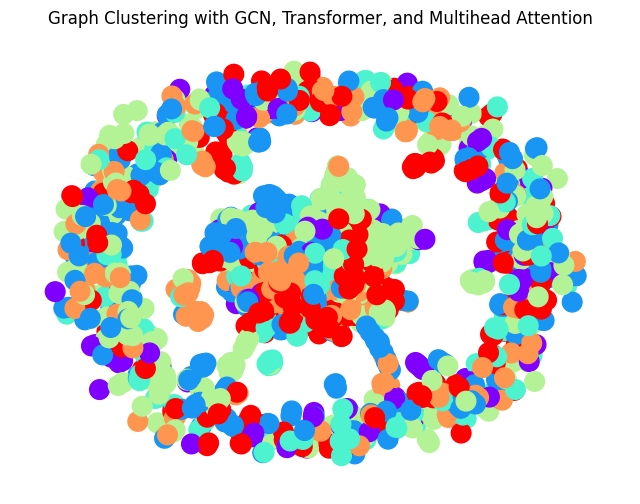

In [ ]:

from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
_, cluster_labels = model(data, data.test_mask)[0].max(dim=1)
G = to_networkx(data.cpu(), to_undirected=True)
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_color=cluster_labels.cpu().detach().numpy(), cmap=plt.cm.rainbow, node_size=200)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Graph Clustering with GCN, Transformer, and Multihead Attention')
plt.show()

In [ ]:
dataset.num_classes

4